<a href="https://colab.research.google.com/github/Hpkarimi/googleColab/blob/main/Fibonacci_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df_all = pd.read_csv('./drive/MyDrive/HistPivot991230Adj.csv'
                 , parse_dates=[0]
                 , index_col=[0])

In [10]:
df_all.replace({0:np.nan}, inplace=True)

In [11]:
bv = df_all['وبوعلی']
bv = bv['2020-01-01':]

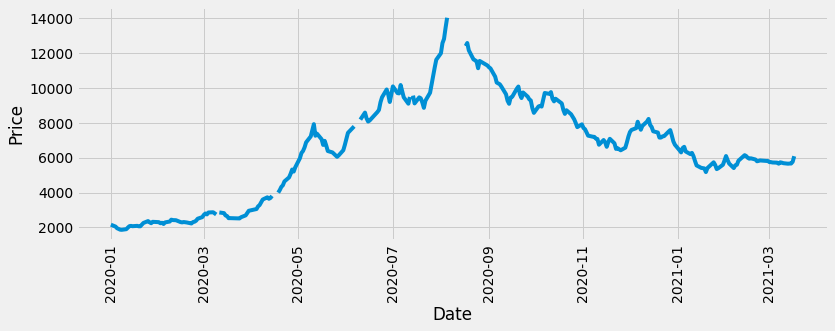

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(bv)
plt.title = 'Close Price'
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

In [13]:
# Finonacci Reteracement
max_price = bv.max()
min_price = bv.min()
diffrence = max_price - min_price
first_level = max_price - diffrence * 0.236
second_level = max_price - diffrence * 0.382
third_level = max_price - diffrence * 0.5
fourth_level = max_price - diffrence * 0.618

In [14]:
# shoet term exponential moving average
ShortEMA = bv.ewm(span=12, adjust=False).mean()
# Long term exponential moving average
LongEMA = bv.ewm(span=26, adjust=False).mean()
# the Moving Average Convergence/Divergence (MACD)
MACD = ShortEMA - LongEMA
# Signal Line
signal = MACD.ewm(span= 9, adjust =False).mean()


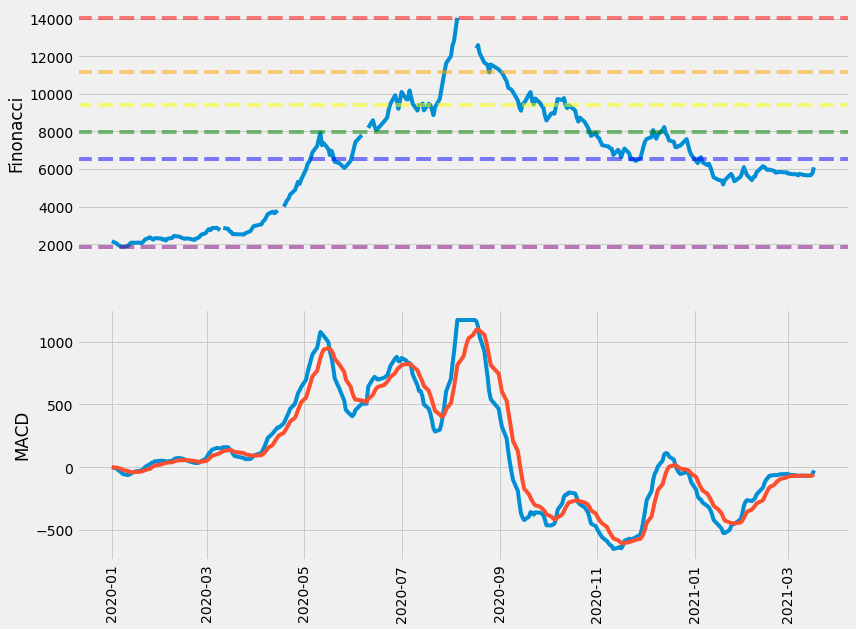

In [15]:
new_df = bv
plt.figure(figsize=(12.33,9.5))
plt.subplot(2,1,1)
plt.plot(new_df.index, new_df)
plt.axhline(max_price, linestyle='--', alpha=0.5, color='red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color='orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color='green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='blue')
plt.axhline(min_price, linestyle='--', alpha=0.5, color='purple')
plt.ylabel('Finonacci')
# plt.xticks(rotation = 90)
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(2,1,2)
plt.plot(new_df.index, MACD)
plt.plot(new_df.index, signal)
plt.ylabel('MACD')
plt.xticks(rotation = 90)

plt.show()

In [16]:
# newbv = pd.DataFrame(data=[bv.values, MACD.values,signal.values], index=bv.index )
newbv = pd.DataFrame(data=bv.values, index=bv.index , columns=['ClosePrice'])
newbv['MACD'] = MACD
newbv['Signal Line'] = signal
newbv

,ClosePrice,MACD,Signal Line
Date,,,
2020-01-01,2158.0,0.000000,0.000000
2020-01-04,2051.0,-8.535613,-1.707123
2020-01-05,1956.0,-22.704134,-5.906525
2020-01-07,1872.0,-40.246945,-12.774609
2020-01-08,1864.0,-54.170835,-21.053854
...,...,...,...
2021-03-13,5660.0,-68.232580,-67.198197
2021-03-14,5670.0,-68.372547,-67.433067
2021-03-15,5670.0,-67.703033,-67.487060


In [17]:
def getlevels(price):
    if price >= first_level:
        return (max_price, first_level)
    elif price >= second_level:
        return (first_level, second_level)
    elif price >= third_level:
        return (second_level, third_level)
    elif price >= fourth_level:
        return (third_level, fourth_level)
    else:
        return (fourth_level, min_price)

In [18]:
# the strategy
# if signal line crosses above the MACD line and the curren price crossed above below the last fibonacci level then buy
# if signal line crosses below the MACD line and the curren price crossed above below the last fibonacci level then sell
# never sell at a price that's lower than i bought

def strategy(df):
    buy_list = []
    sell_list = []
    flag = 0
    last_buy_price =0
    #     loop through the data set
    for i in range(0, df.shape[0]):
        price = df['ClosePrice'][i]
        if i == 0 :
            upper_lvl, lower_lvl = getlevels(price)
            buy_list.append(np.nan)
            sell_list.append(np.nan)
        # ELSE if the current price is greater than or equal to the upper_lvl , or less than or equal to lower_lvl , then we know the price hit or cross a fibonacci lvl
        elif price >= upper_lvl or price <= lower_lvl:
            # check to see if the MACD line above or below the signal line
            if df['Signal Line'][i] > df['MACD'][i] and flag == 0:
                last_buy_price = price
                buy_list.append(price)
                sell_list.append(np.nan)
                # Set the flag to 1 to signal that the share was bought
                flag = 1
            elif df['Signal Line'][i] < df['MACD'][i] and flag == 1 and price >= last_buy_price:
                buy_list.append(np.nan)
                sell_list.append(price)
                flag = 0
            else:
                buy_list.append(np.nan)
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)            

        #update the new levels
        upper_lvl, lower_lvl = getlevels(price)
    return buy_list, sell_list
        

In [19]:
buy, sell = strategy(newbv)
newbv['Buy_Signal_Price'] = buy
newbv['Sell_Signal_Price'] = sell


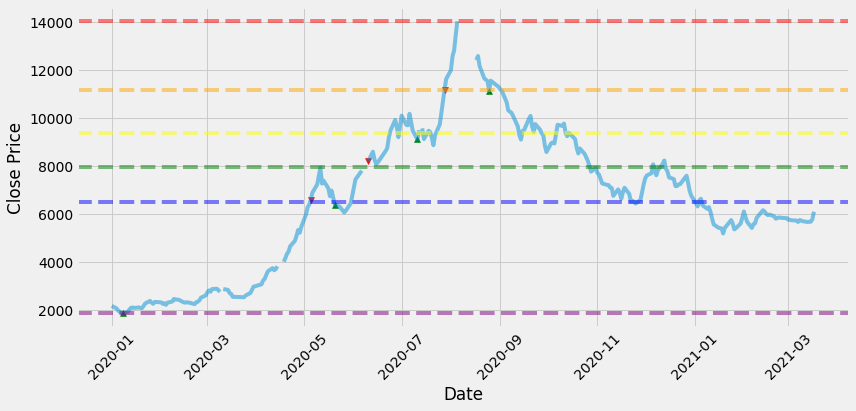

In [20]:
new_df = newbv

plt.figure(figsize=(12.33,5.5))
plt.plot(new_df.index, new_df['ClosePrice'], alpha=0.5)
plt.scatter(new_df.index, new_df['Buy_Signal_Price'], color = 'green', marker='^', alpha=1)
plt.scatter(new_df.index, new_df['Sell_Signal_Price'], color = 'red', marker='v', alpha=1)

plt.axhline(max_price, linestyle='--', alpha=0.5, color='red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color='orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color='green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='blue')
plt.axhline(min_price, linestyle='--', alpha=0.5, color='purple')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.show()
